# Set Up Environment and Load Libraries

In [ ]:
# Import necessary libraries for deep learning and data manipulation
import tensorflow as tf
import numpy as np
import os
import zipfile
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

from PIL import Image



In [ ]:

# Download the dataset using Kaggle API
!kaggle datasets download -d iarunava/cell-images-for-detecting-malaria

# Unzip the downloaded datase
with zipfile.ZipFile('cell-images-for-detecting-malaria.zip', 'r') as zip_ref:
    zip_ref.extractall('data')

Dataset URL: https://www.kaggle.com/datasets/iarunava/cell-images-for-detecting-malaria
License(s): unknown
cell-images-for-detecting-malaria.zip: Skipping, found more recently modified local copy (use --force to force download)


## Summary of my workflow
 - Set Up Environment and Load Libraries
      * Import necessary libraries and download the dataset.
      * Extract the dataset to the specified directory.

# Data Preparation

In [ ]:
# Define the base directory where the dataset is extracted
base_dir = 'data/cell_images'
# Define paths to the infected and uninfected directories
infected_dir = os.path.join(base_dir, 'Parasitized')
uninfected_dir = os.path.join(base_dir, 'Uninfected')

# Print the number of images in each category to verify dataset integrity
print(f'Total infected images: {len(os.listdir(infected_dir))}')
print(f'Total uninfected images: {len(os.listdir(uninfected_dir))}')

Total infected images: 13780
Total uninfected images: 13780


In [ ]:
def load_and_resize_images(folder_path, label, target_size=(100, 100)):
    images = []
    labels = []
    for filename in os.listdir(folder_path):
        if filename.endswith('.jpg') or filename.endswith(".png"):
            try:
                image = Image.open(os.path.join(folder_path, filename))
                # Resize the image to the target size
                image = image.resize(target_size)
                # Convert the image to a numpy array
                image_array = np.array(image)
                images.append(image_array)
                labels.append(label)
            except Exception as e:
                print(f"Error processing {filename}: {str(e)}")
    return images, labels

In [ ]:
# Load and resize images from Parasitized folder
parasitized_images, parasitized_labels = load_and_resize_images(uninfected_dir, label=0)

# Load and resize images from Uninfected folder
uninfected_images, uninfected_labels = load_and_resize_images(uninfected_dir, label=1)

# Concatenate the lists of images and labels
images = parasitized_images + uninfected_images
labels = parasitized_labels + uninfected_labels


In [ ]:
# Convert lists to NumPy arrays
image_data = np.array(images)
label_data = np.array(labels)

# Check the shape of the image data
print("Image data shape:", image_data.shape)


Image data shape: (27558, 100, 100, 3)


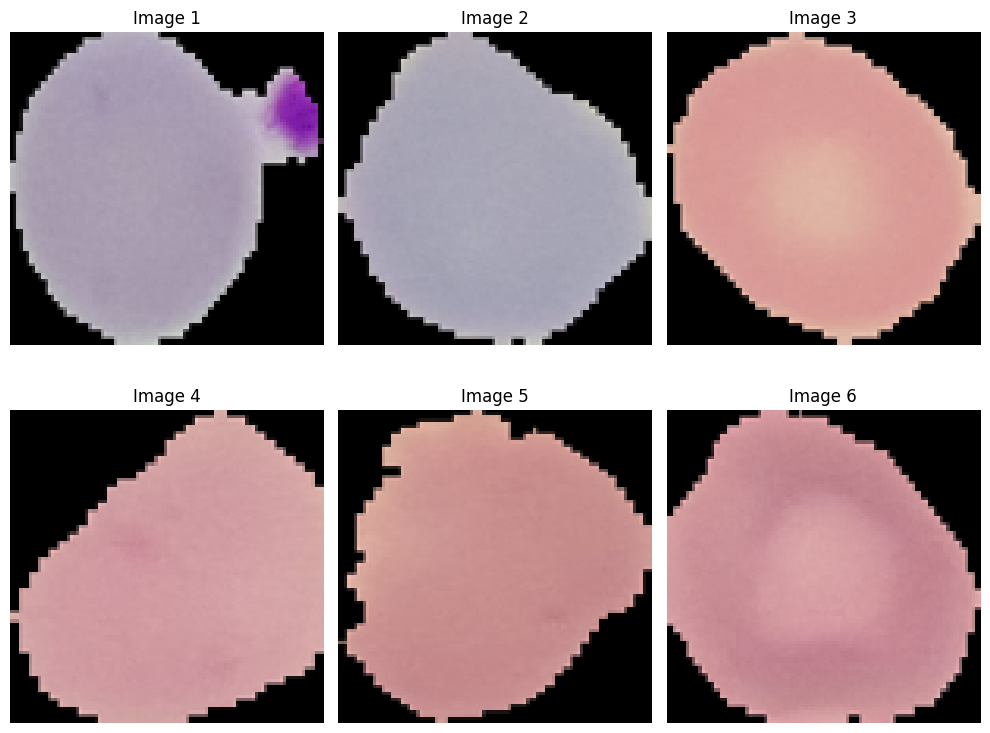

In [ ]:
from matplotlib import pyplot as plt
rows = 2
cols = 3

fig, axes = plt.subplots(rows, cols, figsize=(10, 8))

axes = axes.ravel()

for i in range(rows * cols):
    axes[i].imshow(image_data[i])
    axes[i].set_title(f'Image {i+1}')
    axes[i].axis('off')


plt.tight_layout()
plt.show()

In [ ]:
# Create an ImageDataGenerator for data augmentation and normalization
datagen = ImageDataGenerator(
    rescale=1./255,  # Normalize pixel values to [0, 1] range
    validation_split=0.2,  # Use 20% of the data for validation
    rotation_range=20,  # Randomly rotate images by up to 20 degrees
    width_shift_range=0.2,  # Randomly shift images horizontally by up to 20%
    height_shift_range=0.2,  # Randomly shift images vertically by up to 20%
    shear_range=0.2,  # Apply random shearing transformations
    zoom_range=0.2,  # Randomly zoom into images
    horizontal_flip=True  # Randomly flip images horizontally
)

In [ ]:
# Create training data generator
train_generator = datagen.flow_from_directory(
    base_dir,  # Directory where the dataset is stored
    target_size=(150, 150),  # Resize images to 150x150 pixels
    batch_size=32,  # Number of images to be yielded from the generator per batch
    class_mode='binary',  # Use binary labels
    subset='training'  # Set this generator for training
)

Found 44095 images belonging to 3 classes.


In [ ]:
# Create validation data generator
validation_generator = datagen.flow_from_directory(
    base_dir,  # Directory where the dataset is stored
    target_size=(150, 150),  # Resize images to 150x150 pixels
    batch_size=32,  # Number of images to be yielded from the generator per batch
    class_mode='binary',  # Use binary labels
    subset='validation'  # Set this generator for validation
)

Found 11021 images belonging to 3 classes.


- Data Preparation
    * Define paths for infected and uninfected image directories.
    * Create ImageDataGenerator instances for training and validation with data augmentation.
    * Verify the number of images in each category.

# Model Development

In [ ]:
# Load the pre-trained MobileNetV2 model without the top classification layer
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(150, 150, 3))
# Freeze the base model to prevent its weights from being updated during training
base_model.trainable = False

# Build the model by adding layers on top of the base model
model = Sequential([
    base_model,  # Add the pre-trained base model
    GlobalAveragePooling2D(),  # Add a global average pooling layer
    Dense(1, activation='sigmoid')  # Add a dense layer with sigmoid activation for binary classification
])

In [ ]:
# Compile the model using Adam optimizer and binary cross-entropy loss function
model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])

In [ ]:
# Set up callbacks for early stopping and model checkpointing
early_stopping = EarlyStopping(monitor='val_loss', patience=3)  # Stop training if validation loss doesn't improve for 3 epochs
model_checkpoint = ModelCheckpoint('malaria_AI_model.h5', save_best_only=True, monitor='val_loss')  # Save the best model based on validation loss

In [ ]:
# Train the model using the training and validation data generators
history = model.fit(
    train_generator,  # Training data generator
    epochs=1,  # Number of epochs to train the model
    validation_data=validation_generator,  # Validation data generator
    callbacks=[early_stopping, model_checkpoint]  # Callbacks for early stopping and model checkpointing
)

1378/1378 [==============================] - ETA: 0s - loss: -80.7547 - accuracy: 0.2498

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


1378/1378 [==============================] - 1217s 881ms/step - loss: -80.7547 - accuracy: 0.2498 - val_loss: -164.2443 - val_accuracy: 0.2500


- Model Development

      * Load MobileNetV2 pre-trained model without the top layer and freeze it.
      * Build a new model by adding global average pooling and a dense output layer.
      * Compile the model with Adam optimizer and binary cross-entropy loss.
      * Set up callbacks for early stopping and saving the best model.
      * Train the model using the training and validation generators.

# Model EValuation and Optimization

In [ ]:
# Load the best model from the training process
model.load_weights('malaria_AI_model.h5')

In [ ]:
# Evaluate the model on the validation set to check performance
val_loss, val_accuracy = model.evaluate(validation_generator)
print(f'Validation accuracy: {val_accuracy*100:.2f}%')

345/345 [==============================] - 252s 728ms/step - loss: -164.5343 - accuracy: 0.2500
Validation accuracy: 25.00%


In [ ]:
# Convert the trained model to TensorFlow Lite format for mobile deployment
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

In [ ]:
# Save the TensorFlow Lite model to a file
with open('model.tflite', 'wb') as f:
    f.write(tflite_model)

- Model Evaluation and Optimization

  * Load the best model weights.
  * Evaluate the model on the validation set.
  * Convert the trained model to TensorFlow Lite format for mobile deployment.

# Plotting Training History

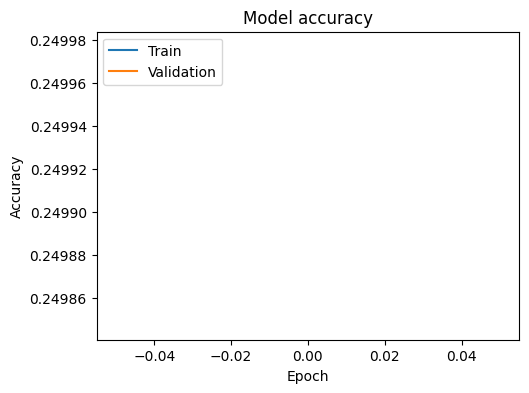

In [ ]:
# Plot accuracy vs epochs
plt.figure(figsize=(12, 4))

# Plot training & validation accuracy values
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

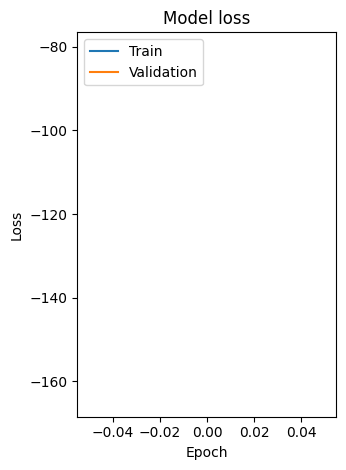

In [ ]:

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')


# Show the plots
plt.tight_layout()
plt.show()

- Plotting Training History

    * Plot the accuracy and loss over epochs for both training and validation sets.